In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import os
import time

sys.path.append(os.path.abspath('..'))

from src.data_loader import get_data_loaders

# load data
print("loading data...")
train_loader, test_loader = get_data_loaders()

# check hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on: {device}")

loading data...
Loading data from: c:\Users\snowf\Desktop\DeepRUL\DeepRUL\data\raw\train_FD001.txt
running on: cpu


In [ ]:
# 1. Vanilla RNN (The "dumb" baseline)
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        out, _ = self.rnn(x)
        # take the last time step
        return self.fc(out[:, -1, :])

# 2. GRU (The "okay" baseline)
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

print("competitor models defined.")

competitor models defined.


In [ ]:
def quick_train(model, name, epochs=5):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    
    print(f"--- training {name} ---")
    start = time.time()
    
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"epoch {epoch+1}: loss {avg_loss:.4f}")
        
    print(f"done in {time.time()-start:.2f}s\n")
    return losses

# init models
rnn = VanillaRNN(input_dim=14, hidden_dim=50, layer_dim=1, output_dim=1)
gru = GRUModel(input_dim=14, hidden_dim=50, layer_dim=1, output_dim=1)

# fight!
rnn_losses = quick_train(rnn, "Vanilla RNN", epochs=5)
gru_losses = quick_train(gru, "GRU", epochs=5)

--- training Vanilla RNN ---
epoch 1: loss 8904.4478
epoch 2: loss 7168.2957
epoch 3: loss 5922.7255
epoch 4: loss 5024.7641
epoch 5: loss 4377.3044
done in 13.90s

--- training GRU ---
epoch 1: loss 8900.1541
epoch 2: loss 7088.5849
epoch 3: loss 5874.1853
epoch 4: loss 4976.4544
epoch 5: loss 4330.1103
done in 35.36s



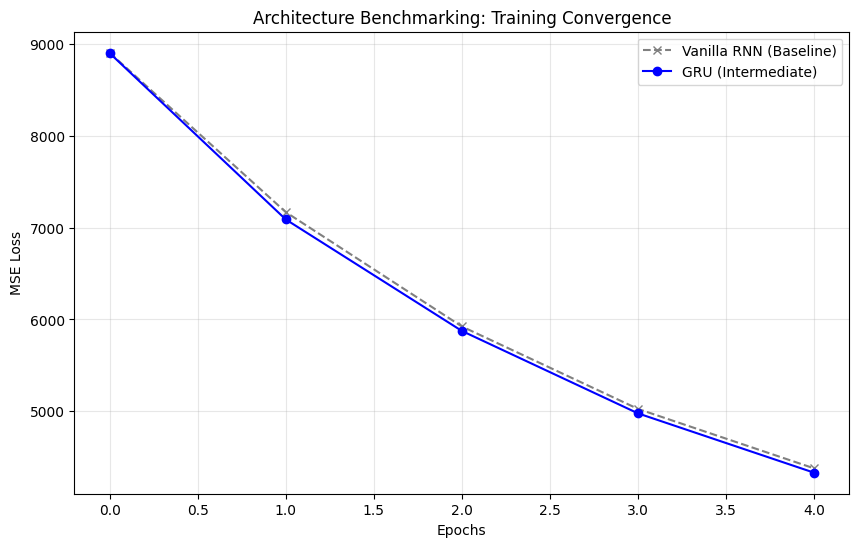

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(rnn_losses, label='Vanilla RNN (Baseline)', linestyle='--', marker='x', color='gray')
plt.plot(gru_losses, label='GRU (Intermediate)', marker='o', color='blue')

plt.title('Architecture Benchmarking: Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()